In [62]:
from PIL import Image
import torch
import os
import numpy as np
import pickle
from utils.utils import *
from utils.file_utils import save_pkl, load_pkl
from models.resnet_custom import resnet50_baseline
from models.model_clam import CLAM_MB, CLAM_SB
from torch.utils.data import DataLoader
from scipy.stats import percentileofscore
import matplotlib.pyplot as plt
from skimage.color import label2rgb
import cv2

In [63]:
drop_out = False
n_classes = 2
model_type = "clam_sb"
model_size = 'small'
exp_code = "exp_6" + "_s1"
ckpt_path = "s_0_checkpoint.pt"
results_dir = "image_sets/results"

data_dir = "image_sets/original/"
image_ext = ".tif"
patch_dir = "image_sets/patches/"
feat_dir = "image_sets/features/"
actual_feat_dir = "image_sets/patches/fungal_vs_nonfungal_resnet_features/pt_files/"

save_path = os.path.join(results_dir, exp_code, "heatmaps")
if not os.path.isdir(save_path):
    os.mkdir(save_path)

In [64]:
# ---------------------------
# Heatmap Image options
patch_size = (256, 256) # patch_size (tuple of int)
binarize = False
overlap = 0
blur = 0
alpha = 1.0
cmap='coolwarm'
thresh = -1
# ---------------------------

In [65]:
heatmap_dict = load_pkl(os.path.join(results_dir, exp_code, "heatmap_dict.pkl"))

In [66]:
image_file = heatmap_dict[0]

image_name = image_file['filename']
attention_scores = image_file['attention_scores']
coords_list = image_file['coords_list']

In [67]:
if isinstance(cmap, str):
    cmap = plt.get_cmap(cmap)

img = np.array(Image.open(os.path.join(data_dir, image_name+image_ext)))
img = img[0:1024, 0:1536] # No left-overs

orig_img = cv2.imread(os.path.join(data_dir, image_name+image_ext))

In [68]:
ref = attention_scores.copy()
scores = []
for score in attention_scores:
    score = percentileofscore(ref, score)
    scores.append(score/100)
print(attention_scores)
print()
print(scores)

[array([[0.9692515]], dtype=float32), array([[0.67974967]], dtype=float32), array([[1.3100058]], dtype=float32), array([[2.115945]], dtype=float32), array([[2.0633273]], dtype=float32), array([[0.3712194]], dtype=float32), array([[2.2165282]], dtype=float32), array([[1.6799694]], dtype=float32), array([[1.261167]], dtype=float32), array([[1.7877005]], dtype=float32), array([[1.2687463]], dtype=float32), array([[2.6665442]], dtype=float32), array([[2.045453]], dtype=float32), array([[1.1738676]], dtype=float32), array([[1.6532478]], dtype=float32), array([[1.4771929]], dtype=float32), array([[2.0641928]], dtype=float32), array([[2.2245715]], dtype=float32), array([[2.155286]], dtype=float32), array([[1.673484]], dtype=float32), array([[1.5258113]], dtype=float32), array([[1.5535276]], dtype=float32), array([[1.2139599]], dtype=float32), array([[0.38763854]], dtype=float32)]

[0.16666666666666669, 0.125, 0.375, 0.8333333333333333, 0.75, 0.04166666666666667, 0.9166666666666667, 0.625, 0.2

In [69]:
if binarize:
    if thresh < 0:
        threshold = 1.0/len(scores)
    else:
        threshold =  thresh
else:
    threshold = 0.0
# print(threshold)

In [70]:
region_size = (1024, 1536)
overlay = np.full(np.flip(region_size), 0).astype(float)
counter = np.full(np.flip(region_size), 0).astype(np.uint16)      
count = 0

In [71]:
for index, score in enumerate(scores):
    coord = coords_list[index]
    coord = [256*x for x in coord]
#         print("coord", coord)
    if score >= threshold:
        if binarize:
            score=1.0
            count+=1
    else:
        score=0.0
#     print(coord[1], coord[1]+patch_size[1], coord[0], coord[0]+patch_size[0])
#     print("(", coord[0], ",", coord[1], ") to (" , coord[0]+patch_size[0], ",", coord[1]+patch_size[1], ")")
    # accumulate attention
    overlay[coord[1]:coord[1]+patch_size[1], coord[0]:coord[0]+patch_size[0]] += score
    # accumulate counter
    counter[coord[1]:coord[1]+patch_size[1], coord[0]:coord[0]+patch_size[0]] += 1
print(len(np.where(overlay == 0)[0]))
print(overlay)

0
[[0.16666667 0.16666667 0.16666667 ... 0.875      0.875      0.875     ]
 [0.16666667 0.16666667 0.16666667 ... 0.875      0.875      0.875     ]
 [0.16666667 0.16666667 0.16666667 ... 0.875      0.875      0.875     ]
 ...
 [0.04166667 0.04166667 0.04166667 ... 0.08333333 0.08333333 0.08333333]
 [0.04166667 0.04166667 0.04166667 ... 0.08333333 0.08333333 0.08333333]
 [0.04166667 0.04166667 0.04166667 ... 0.08333333 0.08333333 0.08333333]]


In [72]:
# # fetch attended region and average accumulated attention
# zero_mask = counter == 0
# # zero_mask is 1 for left-over strips

# if binarize:
#     overlay[~zero_mask] = np.around(overlay[~zero_mask] / counter[~zero_mask])
# else:
#     overlay[~zero_mask] = overlay[~zero_mask] / counter[~zero_mask]
#     # overlay[~zero_mask] is empty for left-over strips, else not.
# del counter 

0.16666666666666669 [0, 0]
0.125 [0, 1]
0.375 [0, 2]
0.8333333333333333 [0, 3]
0.75 [0, 4]
0.04166666666666667 [0, 5]
0.9166666666666667 [1, 0]
0.625 [1, 1]
0.2916666666666667 [1, 2]
0.6666666666666667 [1, 3]
0.33333333333333337 [1, 4]
1.0 [1, 5]
0.7083333333333333 [2, 0]
0.20833333333333331 [2, 1]
0.5416666666666666 [2, 2]
0.41666666666666663 [2, 3]
0.7916666666666667 [2, 4]
0.9583333333333333 [2, 5]
0.875 [3, 0]
0.5833333333333334 [3, 1]
0.45833333333333337 [3, 2]
0.5 [3, 3]
0.25 [3, 4]
0.08333333333333334 [3, 5]


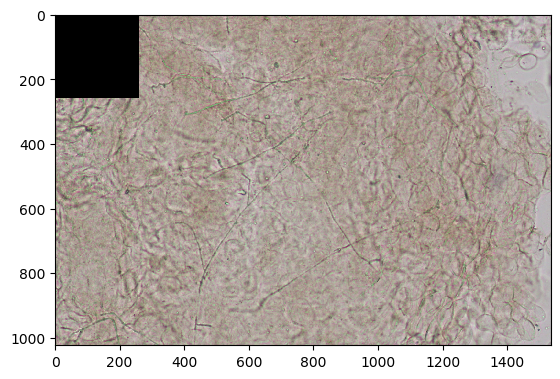

In [73]:
for index, score in enumerate(scores):
    coord = coords_list[index]
    print(score, coord)
    
    label = np.ones([256, 256])
    label = label * score
#     print(label)
    
    img_block = img[coord[1]:coord[1]+patch_size[1], coord[0]:coord[0]+patch_size[0]].copy()
    
    img_1 = label2rgb(label, img_block, color)

    # rewrite image block
    img[coord[1]:coord[1]+patch_size[1], coord[0]:coord[0]+patch_size[0]] = img_1.copy()
plt.imshow(img)

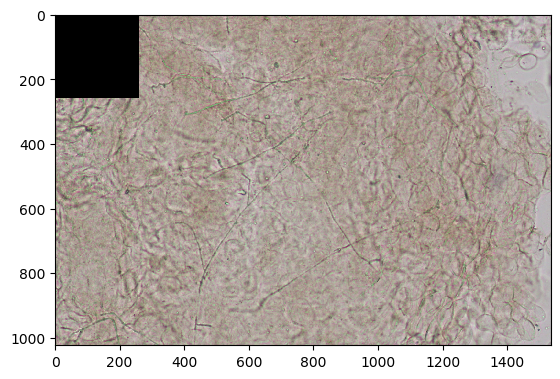

In [74]:
if blur:
    img = cv2.GaussianBlur(img,tuple((patch_size * (1-overlap)).astype(int) * 2 +1),0)  

if alpha < 1.0:
    img = self.block_blending(img, vis_level, top_left, bot_right, alpha=alpha, blank_canvas=blank_canvas, block_size=1024)

img = Image.fromarray(img)

plt.imshow(img)